In [53]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import logging
import matplotlib.pyplot as plt

import sys
sys.path.append("./experiments/siammask_sharp/")
from custom import Custom

sys.path.append("./")
from utils.load_helper import load_pretrain
from tools.test import siamese_init, siamese_track

In [25]:
import json

def proccess_loss(cfg):
    if 'reg' not in cfg:
        cfg['reg'] = {'loss': 'L1Loss'}
    else:
        if 'loss' not in cfg['reg']:
            cfg['reg']['loss'] = 'L1Loss'

    if 'cls' not in cfg:
        cfg['cls'] = {'split': True}

    cfg['weight'] = cfg.get('weight', [1, 1, 36])  # cls, reg, mask
    
def load_config(config_path,clip=None):
    config = json.load(open(config_path))

    # deal with network
    if 'network' not in config:
        print('Warning: network lost in config. This will be error in next version')

        config['network'] = {}

        if not args.arch:
            raise Exception('no arch provided')
    arch = config['network']['arch']

    # deal with loss
    if 'loss' not in config:
        config['loss'] = {}

    proccess_loss(config['loss'])

    # deal with lr
    if 'lr' not in config:
        config['lr'] = {}
    default = {
            'feature_lr_mult': 1.0,
            'rpn_lr_mult': 1.0,
            'mask_lr_mult': 1.0,
            'type': 'log',
            'start_lr': 0.03
            }
    default.update(config['lr'])
    config['lr'] = default

    # clip
    if clip:
        if 'clip' not in config:
            config['clip'] = {}
        config['clip'] = add_default(config['clip'],
                {'feature': clip, 'rpn': clip, 'split': False})
        if config['clip']['feature'] != config['clip']['rpn']:
            config['clip']['split'] = True
        if not config['clip']['split']:
            clip = config['clip']['feature']

    return config, arch,clip

In [16]:
config_path = "./experiments/siammask_sharp/config_davis.json"
resume = "./experiments/siammask_sharp/SiamMask_DAVIS.pth"

In [11]:
cfg = load_config(config_path)[0]

In [12]:
siammask = Custom(anchors=cfg['anchors'])
siammask = load_pretrain(siammask, resume)
_ = siammask.eval().to('cuda')

In [30]:
test_path = "../sample_pose.jpg"

In [31]:
img = cv2.imread(test_path)

In [51]:
ims=[img,img,img]

In [48]:
x,y,w,h = 20,210,120,320 # example init rect

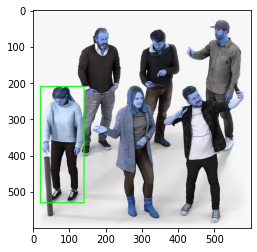

In [47]:
dimg = img.copy()
dimg = cv2.rectangle(dimg,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(dimg)

In [56]:
for f,im in enumerate(ims):
    if f==0: # init
        target_pos = np.array([x+w/2,y+h/2])
        target_sz = np.array([w,h])
        state = siamese_init(im,target_pos, target_sz, siammask, cfg['hp'], device='cuda')
    elif f>0:
        state = siamese_track(state, im, mask_enable=True, refine_enable=True,device='cuda')
        location = state['ploygon'].flatten()
        mask = state['mask'] > state['p'].seg_thr
        
        im[:, :, 2] = (mask > 0) * 255 + (mask == 0) * im[:, :, 2]
        cv2.polylines(im, [np.int0(location).reshape((-1, 1, 2))], True, (0, 255, 0), 3)
        break

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


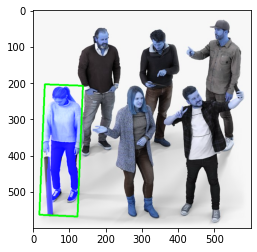

In [57]:
plt.imshow(im)